In [ ]:
!nvidia-smi

Fri Jan 23 04:46:29 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Настройка

In [ ]:
!pip install -q onnxruntime onnxscript torch-pruning

In [ ]:
import time, os, io
from copy import deepcopy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

from torchvision import datasets, transforms
import onnxruntime as ort
import torch_pruning as tp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Модель и данные

In [ ]:
batch_size = 128

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

100%|██████████| 170M/170M [00:05<00:00, 28.5MB/s]


In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN().to(device)
sum(p.numel() for p in model.parameters()) / 1e6

2.193226

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    t0 = time.time()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    t1 = time.time()
    return running_loss / total, correct / total, t1 - t0

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    t0 = time.time()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    t1 = time.time()
    return correct / total, t1 - t0

In [ ]:
model_base = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_base.parameters(), lr=1e-3)

num_epochs = 25
for epoch in range(num_epochs):
    train_loss, train_acc, train_time = train_one_epoch(model_base, train_loader, optimizer, criterion, device)
    test_acc, test_time = evaluate(model_base, test_loader, device)
    print(f"Epoch {epoch+1}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
          f"test_acc={test_acc:.3f}, train_time={train_time:.2f}s, "
          f"test_time={test_time:.2f}s")

Epoch 1: train_loss=1.6175, train_acc=0.409, test_acc=0.541, train_time=13.53s, test_time=1.41s
Epoch 2: train_loss=1.2349, train_acc=0.555, test_acc=0.642, train_time=13.09s, test_time=1.39s
Epoch 3: train_loss=1.0503, train_acc=0.629, test_acc=0.679, train_time=13.31s, test_time=1.38s
Epoch 4: train_loss=0.9377, train_acc=0.670, test_acc=0.724, train_time=13.05s, test_time=1.38s
Epoch 5: train_loss=0.8525, train_acc=0.700, test_acc=0.741, train_time=13.31s, test_time=1.39s
Epoch 6: train_loss=0.7939, train_acc=0.722, test_acc=0.742, train_time=13.30s, test_time=2.18s
Epoch 7: train_loss=0.7446, train_acc=0.739, test_acc=0.764, train_time=13.29s, test_time=1.38s
Epoch 8: train_loss=0.7018, train_acc=0.754, test_acc=0.779, train_time=13.16s, test_time=1.41s
Epoch 9: train_loss=0.6735, train_acc=0.764, test_acc=0.763, train_time=13.26s, test_time=1.37s
Epoch 10: train_loss=0.6452, train_acc=0.775, test_acc=0.779, train_time=13.17s, test_time=1.38s
Epoch 11: train_loss=0.6148, train_acc=

In [ ]:
save_path = "smallcnn_fp32.pth"
torch.save(model_base.state_dict(), save_path)

In [ ]:
@torch.no_grad()
def benchmark_inference(model, loader, device, num_batches=50, warmup=10):
    model.eval()
    times = []
    it = iter(loader)

    # прогрев
    for _ in range(warmup):
        images, _ = next(it)
        images = images.to(device)
        _ = model(images)

    torch.cuda.synchronize() if device.type == "cuda" else None

    it = iter(loader)
    for i in range(num_batches):
        images, _ = next(it)
        images = images.to(device)
        start = time.time()
        _ = model(images)
        torch.cuda.synchronize() if device.type == "cuda" else None
        end = time.time()
        times.append(end - start)

    return sum(times) / len(times)

base_batch_time = benchmark_inference(model_base, test_loader, device, num_batches=30)
print(f"Base model avg batch inference time: {base_batch_time*1000:.2f} ms")

Base model avg batch inference time: 5.02 ms


### Квантизация

Квантизация представляет собой процесс отображения непрерывного множества вещественных чисел в конечное множество дискретных значений

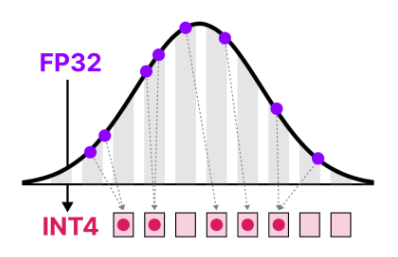

Визуализация количества бит в разных типах

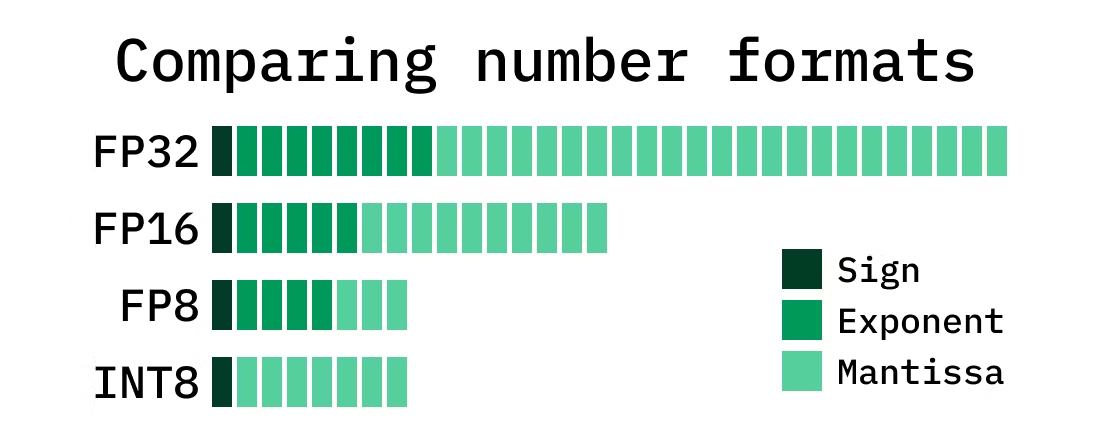

Зачем?

- Операции над INT8 часто выполняются быстрее, чем FP32
- Веса в INT8 занимают ~4× меньше памяти, чем FP32.
- Меньше тензоры — меньше трафик между RAM / GPU / кешами → быстрее.

#### Динамическая квантизация

Идея:
- Квантовать только веса (например, слои Linear), активации остаются FP32
- Квантование/деквантование происходит "на лету" во время выполнения
- Часто используется для RNN/Transformer‑моделей на CPU
- Простая в применении, почти не требует данных.

`torch.quantization.quantize_dynamic` - weight-only quantization

In [ ]:
model_cpu = deepcopy(model_base).to("cpu").eval()

# Dynamic quantization
quantized_dynamic = torch.quantization.quantize_dynamic(
    model_cpu, {nn.Linear}, dtype=torch.qint8
)
print(quantized_dynamic)

# Память / число параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("Base (CPU) params:", count_parameters(model_cpu))
print("Dynamic quantized params:", count_parameters(quantized_dynamic))

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): DynamicQuantizedLinear(in_features=8192, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (2): ReLU(inplace=True)
    (3): DynamicQuantizedLinear(in_features=256, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  )
)
Base (CPU) params: 2193226
Dynamic quantized params: 93248


/tmp/ipython-input-3835985310.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_dynamic = torch.quantization.quantize_dynamic(


In [ ]:
test_loader_cpu = DataLoader(
    test_dataset, batch_size=256, shuffle=False, num_workers=2, pin_memory=False
)

def benchmark_cpu(model, loader, num_batches=50, warmup=10):
    model.eval()
    correct = 0
    total = 0

    times = []
    it = iter(loader)
    for _ in range(warmup):
        images, labels = next(it)
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    it = iter(loader)
    for _ in range(num_batches):
        images, labels = next(it)
        start = time.time()
        outputs = model(images)
        end = time.time()
        times.append(end - start)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return sum(times) / len(times), correct / total

base_cpu_time, base_accuracy = benchmark_cpu(model_cpu, test_loader_cpu, num_batches=30)
dynq_cpu_time, dynq_accuracy = benchmark_cpu(quantized_dynamic, test_loader_cpu, num_batches=30)

print(f"Base CPU batch time: {base_cpu_time*1000:.2f} ms, accuracy: {base_accuracy*100:.2f}%")
print(f"Dynamic quantized CPU batch time: {dynq_cpu_time*1000:.2f} ms, accuracy: {dynq_accuracy*100:.2f}%")

Base CPU batch time: 483.82 ms, accuracy: 81.44%
Dynamic quantized CPU batch time: 502.19 ms, accuracy: 81.49%


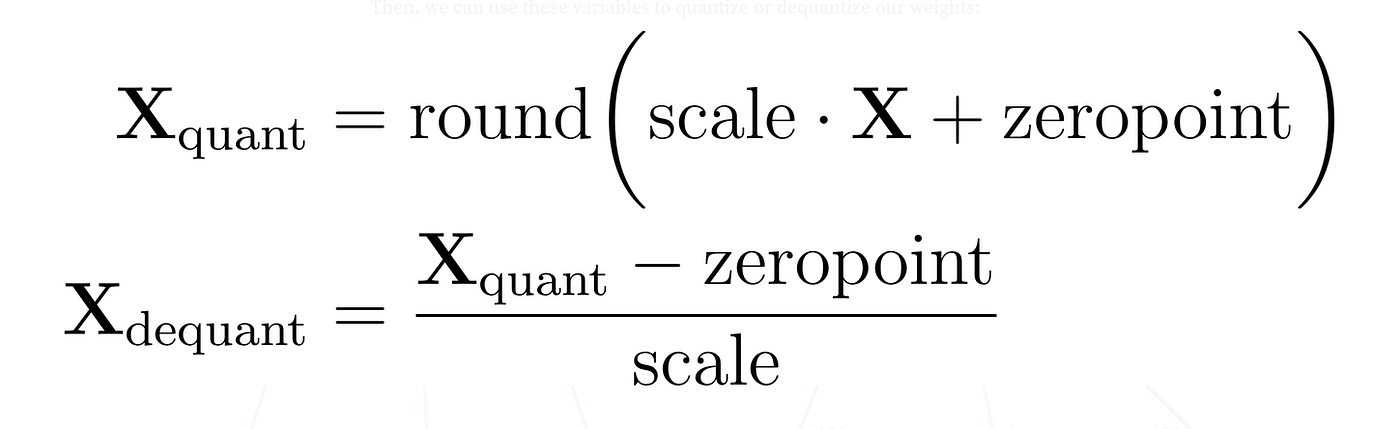

1. PyTorch проходит по всем модулям и находит те, что указаны в qconfig_spec (например, nn.Linear).
2. Каждый найденный модуль заменяется на динамически квантованный аналог (например, torch.nn.quantized.dynamic.Linear).
3. Для каждого слоя веса конвертируются в int8:
- Вычисляется scale и zero_point для весов (обычно per-channel для лучшей точности).
- Веса хранятся в quantized representation.


4. Во время inference для каждого forward pass:
- Входящие активации (float32) квантуются динамически
​
- Выполняется int8 матричное умножение/свёртка с квантованными весами.
​
- Результат декватизуется обратно в float32.
​

#### Статическая квантизация

Идея:
- Квантовать веса и активации.
- Требует калибровки на реальных или похожих данных, чтобы оценить диапазон значений активаций (min/max, статистики).
- Хорошо подходит для CNN на CPU с поддержкой FBGEMM/QNNPACK.

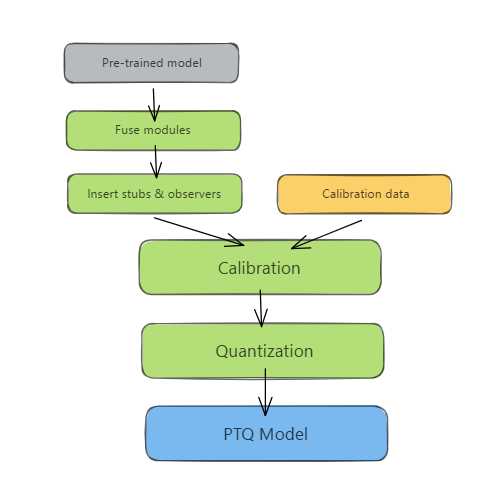

Параметры квантизации для активаций (scale/zero_point) заранее оцениваются на калибровочных данных!

In [ ]:
class SmallCNNQuant(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.quant(x)        # float32 -> quant
        x = self.features(x)
        x = self.classifier(x)
        x = self.dequant(x)      # quant -> float32 (если нужно)
        return x

    def fuse_model(self):
        # self.features: 0 Conv, 1 ReLU, 2 Conv, 3 ReLU, 4 MaxPool, 5 Conv, 6 ReLU, 7 MaxPool
        torch.quantization.fuse_modules(self.features, [['0', '1'], ['2', '3'], ['5', '6']], inplace=True)
        # self.classifier: 0 Flatten, 1 Linear, 2 ReLU, 3 Linear
        torch.quantization.fuse_modules(self.classifier, [['1', '2']], inplace=True)

In [ ]:
model_quant = SmallCNNQuant()
state_dict = model_base.to("cpu").state_dict()
model_quant.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

`fuse_model` сливает (fuse) последовательности модулей в один модуль для более эффективного инференса и лучшей квантизации.

Фьюзинг поддерживает типовые паттерны вроде conv+bn, conv+bn+relu, conv+relu, linear+relu, bn+relu, а остальные последовательности оставляет без изменений; первый модуль в списке заменяется на fused-версию, остальные заменяются на Identity.

In [ ]:
model_quant.fuse_model()

QConfig - пара из observer для активаций и observer для весов, настроенная под бэкенд FBGEMM (x86/серверный CPU).


In [ ]:
model_quant.qconfig = torch.quantization.get_default_qconfig("fbgemm")
model_quant.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

Вставляем observer’ы в нужные места (и/или активирует уже вставленные stubs), чтобы во время калибровки собрать статистику активаций для вычисления scale/zero_point

In [ ]:
model_quant = torch.quantization.prepare(model_quant)
model_quant.eval()

/tmp/ipython-input-2522865446.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quant = torch.quantization.prepare(model_quant)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of

SmallCNNQuant(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (dequant): DeQuantStub()
  (features): Sequential(
    (0): ConvReLU2d(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (1): Identity()
    (2): ConvReLU2d(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (3): Identity()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ConvReLU2d(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, paddin

Калибровка

In [ ]:
calibration_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)

In [ ]:
# calibration_loader: любой DataLoader без аугментаций, батчи как при инференсе
with torch.inference_mode():
  it = iter(calibration_loader)
  for _ in range(30): # 30 батчей
    images, _ = next(it)
    _ = model_quant(images.to("cpu"))

Финально заменяем float-модули на квантованные аналоги и материализуем вычисленные qparams (scale/zero_point), а также заменяем QuantStub/DeQuantStub на реальные quantize/dequantize операции


In [ ]:
model_int8 = torch.quantization.convert(model_quant, inplace=False)
print("Quantized model:\n", model_int8)

Quantized model:
 SmallCNNQuant(
  (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (features): Sequential(
    (0): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.010979210026562214, zero_point=0, padding=(1, 1))
    (1): Identity()
    (2): QuantizedConvReLU2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01324539165943861, zero_point=0, padding=(1, 1))
    (3): Identity()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.015210763551294804, zero_point=0, padding=(1, 1))
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): QuantizedLinearReLU(in_features=8192, out_features=256, scale=0.1286807507276535, zero_point=0, qscheme=torch.per_channel_affin

/tmp/ipython-input-3293587177.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = torch.quantization.convert(model_quant, inplace=False)


In [ ]:
@torch.no_grad()
def accuracy_cpu(model, loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return correct / total

int8_acc = accuracy_cpu(model_int8, test_loader_cpu)
base_acc = accuracy_cpu(model_base.to("cpu"), test_loader_cpu)

int8_time = benchmark_cpu(model_int8, test_loader_cpu, num_batches=30)

print(f"Base CPU acc: {base_acc:.3f}, time: {base_cpu_time*1000:.2f} ms")
print(f"INT8 CPU acc: {int8_acc:.3f}, time: {int8_time*1000:.2f} ms")
print(f"Speedup: {base_cpu_time / int8_time:.2f}x")

In [ ]:
base_cpu_time, base_accuracy = benchmark_cpu(model_cpu, test_loader_cpu, num_batches=30)
statq_cpu_time, statq_accuracy = benchmark_cpu(model_int8, test_loader_cpu, num_batches=30)

print(f"Base CPU batch time: {base_cpu_time*1000:.2f} ms, accuracy: {base_accuracy*100:.2f}%")
print(f"Static quantized CPU batch time: {statq_cpu_time*1000:.2f} ms, accuracy: {statq_accuracy*100:.2f}%")

Base CPU batch time: 510.70 ms, accuracy: 81.44%
Static quantized CPU batch time: 303.92 ms, accuracy: 81.39%


In [ ]:
print(f"Speedup: {base_cpu_time / statq_cpu_time:.2f}x")

Speedup: 1.68x


In [ ]:
def get_state_dict_size_bytes(state_dict):
    buffer = io.BytesIO()
    torch.save(state_dict, buffer)
    return buffer.getbuffer().nbytes

# FP32 модель до квантования
fp32_sd = model_cpu.state_dict()
fp32_size = get_state_dict_size_bytes(fp32_sd)

# INT8 модель после convert()
int8_sd = model_int8.state_dict()
int8_size = get_state_dict_size_bytes(int8_sd)

print(f"FP32 state_dict: {fp32_size/1024**2:.2f} MB")
print(f"INT8 state_dict: {int8_size/1024**2:.2f} MB")
print(f"Сжатие по весам: x{fp32_size / int8_size:.2f}")


FP32 state_dict: 8.37 MB
INT8 state_dict: 2.11 MB
Сжатие по весам: x3.97


#### Соберем все в кучку

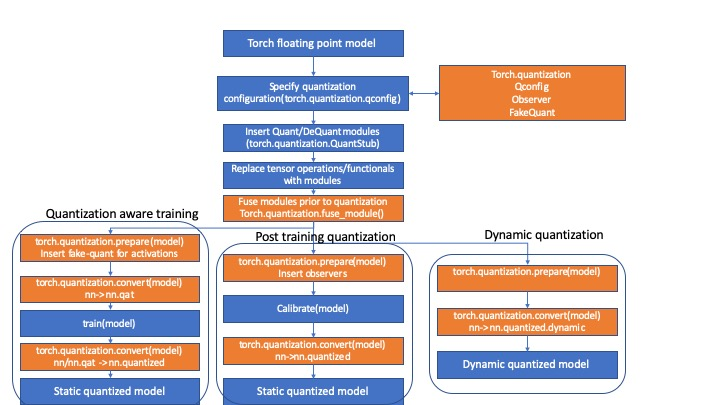

### Дистилляция

Дистилляция - техника, при которой "большая, умная" модель (teacher) обучает "маленькую, быструю" модель (student) не только по истинным меткам, но и по своим собственным предсказаниям (soft‑логиты).

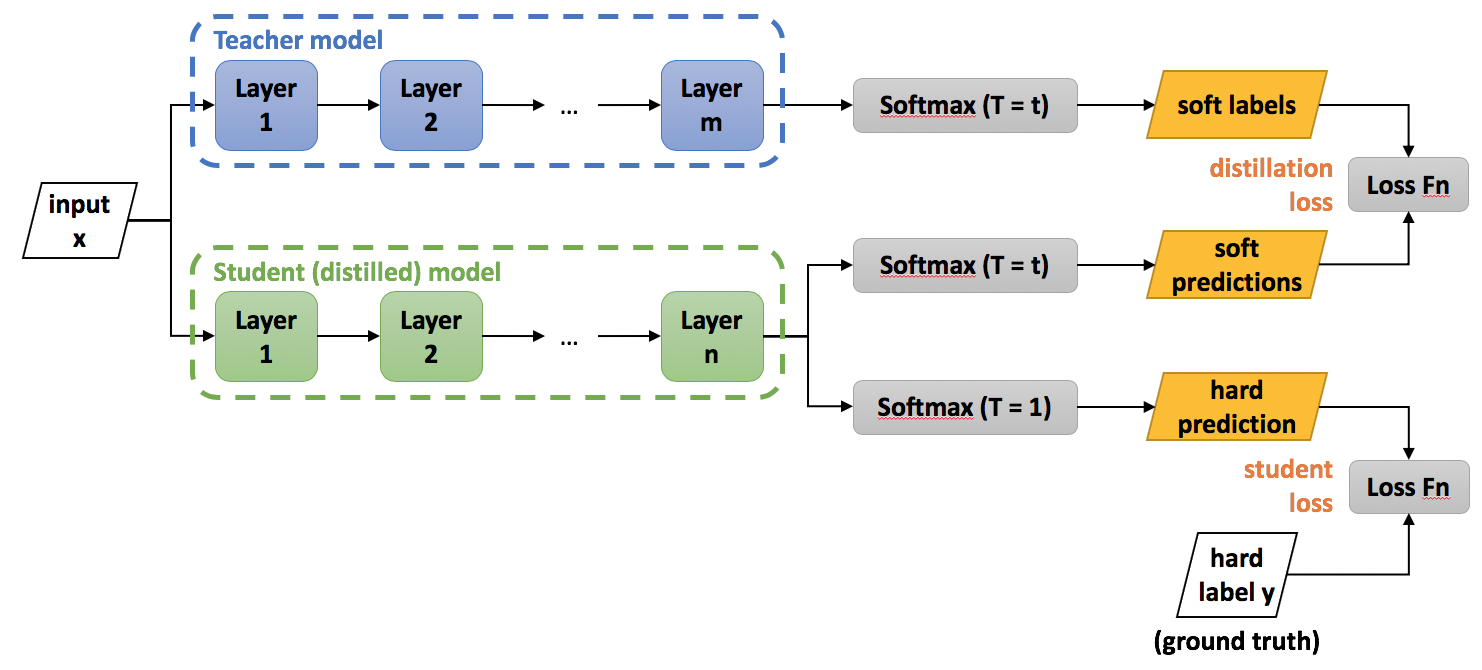

Зачем?

- Student‑модель имеет меньше параметров и вычислений → быстрее на проде.
- Вместо того чтобы просто обучить маленькую модель на тех же данных, используем знания учителя: его вероятности по всем классам, структуру ошибок.
- Soft‑targets содержат информацию о близости классов, недоступную в one‑hot метках.

In [ ]:
# Память / число параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [ ]:
model_base = SmallCNN()
checkpoint = torch.load("smallcnn_fp32.pth", map_location="cpu")
model_base.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
model_base.to(device)

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
class SmallCNNStudent(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

student = SmallCNNStudent().to(device)
print("Teacher params (M):", count_parameters(model_base) / 1e6)
print("Student params (M):", count_parameters(student) / 1e6)

Teacher params (M): 2.193226
Student params (M): 0.269594


Базовое качество

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student.parameters(), lr=1e-3)

num_epochs = 25
for epoch in range(num_epochs):
    train_loss, train_acc, train_time = train_one_epoch(student, train_loader, optimizer, criterion, device)
    test_acc, test_time = evaluate(student, test_loader, device)
    print(f"Epoch {epoch+1}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
          f"test_acc={test_acc:.3f}, train_time={train_time:.2f}s, "
          f"test_time={test_time:.2f}s")

Epoch 1: train_loss=1.8251, train_acc=0.335, test_acc=0.460, train_time=13.24s, test_time=1.41s
Epoch 2: train_loss=1.5336, train_acc=0.446, test_acc=0.516, train_time=13.03s, test_time=1.40s
Epoch 3: train_loss=1.4160, train_acc=0.491, test_acc=0.546, train_time=13.12s, test_time=1.36s
Epoch 4: train_loss=1.3390, train_acc=0.522, test_acc=0.571, train_time=12.93s, test_time=1.36s
Epoch 5: train_loss=1.2728, train_acc=0.544, test_acc=0.598, train_time=12.99s, test_time=1.37s
Epoch 6: train_loss=1.2102, train_acc=0.569, test_acc=0.614, train_time=13.06s, test_time=1.72s
Epoch 7: train_loss=1.1727, train_acc=0.583, test_acc=0.629, train_time=13.20s, test_time=1.72s
Epoch 8: train_loss=1.1218, train_acc=0.601, test_acc=0.644, train_time=13.06s, test_time=1.36s
Epoch 9: train_loss=1.1002, train_acc=0.609, test_acc=0.648, train_time=13.05s, test_time=1.38s
Epoch 10: train_loss=1.0587, train_acc=0.626, test_acc=0.643, train_time=12.98s, test_time=1.38s
Epoch 11: train_loss=1.0314, train_acc=

In [ ]:
def distillation_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    # CE по меткам
    ce = F.cross_entropy(student_logits, labels)

    # KL между распределениями teacher и student с темп-ой
    p_teacher = F.log_softmax(teacher_logits / T, dim=1)
    p_student = F.log_softmax(student_logits / T, dim=1)
    kl = F.kl_div(p_student, p_teacher.exp(), reduction="batchmean") * (T * T)

    return alpha * kl + (1 - alpha) * ce

In [ ]:
student = SmallCNNStudent().to(device)
teacher = deepcopy(model_base).eval().to(device)
for p in teacher.parameters():
    p.requires_grad_(False)

optimizer_s = optim.Adam(student.parameters(), lr=1e-3)

epochs_distill = 25

for epoch in range(epochs_distill):
    student.train()
    running_loss = 0.0
    correct = 0
    total = 0
    t0 = time.time()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            t_logits = teacher(images)

        s_logits = student(images)
        loss = distillation_loss(s_logits, t_logits, labels, T=1.2, alpha=0.5)

        optimizer_s.zero_grad()
        loss.backward()
        optimizer_s.step()

        running_loss += loss.item() * images.size(0)
        _, preds = s_logits.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    test_acc, test_time = evaluate(student, test_loader, device)
    print(f"Epoch {epoch+1} (distill): "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
          f"test_acc={test_acc:.3f}")

Epoch 1 (distill): train_loss=1.7975, train_acc=0.352, test_acc=0.461
Epoch 2 (distill): train_loss=1.4579, train_acc=0.463, test_acc=0.520
Epoch 3 (distill): train_loss=1.3373, train_acc=0.499, test_acc=0.549
Epoch 4 (distill): train_loss=1.2389, train_acc=0.536, test_acc=0.584
Epoch 5 (distill): train_loss=1.1504, train_acc=0.563, test_acc=0.618
Epoch 6 (distill): train_loss=1.0828, train_acc=0.587, test_acc=0.640
Epoch 7 (distill): train_loss=1.0182, train_acc=0.604, test_acc=0.656
Epoch 8 (distill): train_loss=0.9713, train_acc=0.622, test_acc=0.634
Epoch 9 (distill): train_loss=0.9352, train_acc=0.634, test_acc=0.676
Epoch 10 (distill): train_loss=0.8954, train_acc=0.647, test_acc=0.687
Epoch 11 (distill): train_loss=0.8633, train_acc=0.657, test_acc=0.693
Epoch 12 (distill): train_loss=0.8402, train_acc=0.665, test_acc=0.702
Epoch 13 (distill): train_loss=0.8163, train_acc=0.671, test_acc=0.708
Epoch 14 (distill): train_loss=0.7940, train_acc=0.680, test_acc=0.714
Epoch 15 (disti

In [ ]:
teacher_time = benchmark_inference(model_base, test_loader, device, num_batches=30)
student_time = benchmark_inference(student, test_loader, device, num_batches=30)

teacher_acc, _ = evaluate(teacher, test_loader, device)
student_acc, _ = evaluate(student, test_loader, device)

print(f"Teacher: acc={teacher_acc:.3f}, time={teacher_time*1000:.2f} ms/batch")
print(f"Student: acc={student_acc:.3f}, time={student_time*1000:.2f} ms/batch")
print(f"Speedup: {teacher_time / student_time:.2f}x, "
      f"Param ratio: {count_parameters(teacher)/count_parameters(student):.2f}x")

Teacher: acc=0.819, time=4.57 ms/batch
Student: acc=0.744, time=1.30 ms/batch
Speedup: 3.53x, Param ratio: 8.14x


### Прунинг

Прунинг - удаление (или обнуление) части параметров модели, чтобы сделать её:

- меньше по размеру,
- потенциально быстрее на инференсе.

In [ ]:
pruned_model = deepcopy(model_base).to(device)

parameters_to_prune = []
for name, module in pruned_model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        parameters_to_prune.append((module, "weight"))

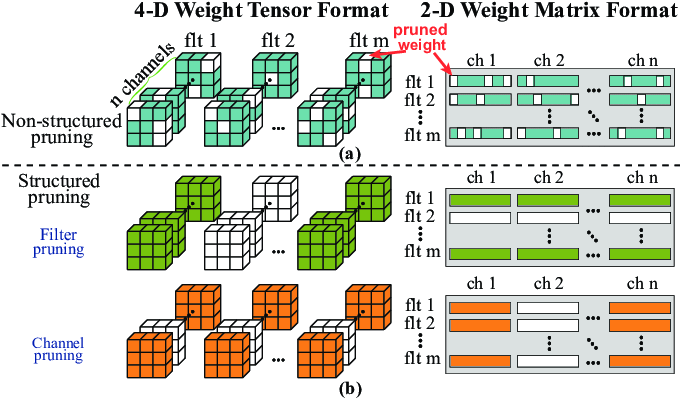

#### Unstructured прунинг

- Обнуляем отдельные веса по какому‑то критерию (например, по L1‑норме: самые маленькие → ноль).
- Получаем «разреженные» матрицы (много нулей, но та же форма).

In [ ]:
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.8, # 80% sparsity
)

In [ ]:
def compute_sparsity(model):
    total_zeros = 0
    total_params = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            w = module.weight.detach()
            total_zeros += (w == 0).sum().item()
            total_params += w.numel()
    return total_zeros / total_params

print("Sparsity:", compute_sparsity(pruned_model))

Sparsity: 0.8000000912102506


In [ ]:
pruned_acc, _ = evaluate(pruned_model, test_loader, device)
pruned_time = benchmark_inference(pruned_model, test_loader, device, num_batches=30)

print(f"Base model: acc={teacher_acc:.3f}, time={teacher_time*1000:.2f} ms/batch")
print(f"Pruned model: acc={pruned_acc:.3f}, time={pruned_time*1000:.2f} ms/batch")

Base model: acc=0.819, time=4.57 ms/batch
Pruned model: acc=0.755, time=4.77 ms/batch


In [ ]:
fp32_sd = teacher.state_dict()
fp32_size = get_state_dict_size_bytes(fp32_sd)

pruned_sd = pruned_model.state_dict()
pruned_size = get_state_dict_size_bytes(pruned_sd)

print(f"FP32 state_dict: {fp32_size/1024**2:.2f} MB")
print(f"INT8 state_dict: {pruned_size/1024**2:.2f} MB")
print(f"Сжатие по весам: x{fp32_size / pruned_size:.2f}")

FP32 state_dict: 8.37 MB
INT8 state_dict: 16.74 MB
Сжатие по весам: x0.50


Подчистим лишнее

In [ ]:
for module, param_name in parameters_to_prune:
  prune.remove(module, param_name)

In [ ]:
pruned_acc, _ = evaluate(pruned_model, test_loader, device)
pruned_time = benchmark_inference(pruned_model, test_loader, device, num_batches=30)

print(f"Base model: acc={teacher_acc:.3f}, time={teacher_time*1000:.2f} ms/batch")
print(f"Pruned model: acc={pruned_acc:.3f}, time={pruned_time*1000:.2f} ms/batch")

Base model: acc=0.819, time=4.57 ms/batch
Pruned model: acc=0.755, time=4.57 ms/batch


In [ ]:
fp32_sd = teacher.state_dict()
fp32_size = get_state_dict_size_bytes(fp32_sd)

pruned_sd = pruned_model.state_dict()
pruned_size = get_state_dict_size_bytes(pruned_sd)

print(f"FP32 state_dict: {fp32_size/1024**2:.2f} MB")
print(f"INT8 state_dict: {pruned_size/1024**2:.2f} MB")
print(f"Сжатие по весам: x{fp32_size / pruned_size:.2f}")

FP32 state_dict: 8.37 MB
INT8 state_dict: 8.37 MB
Сжатие по весам: x1.00


#### Structured прунинг

Удаляем целые:
- каналы/фильтры в Conv,
- нейроны/строки/столбцы в Linear.

In [ ]:
structured_model = deepcopy(model_base).to(device)

In [ ]:
conv_layers = []
for name, m in model.named_modules():
  if isinstance(m, nn.Conv2d):
    # зануляем целые выходные каналы с наименьшей L_n нормой
    prune.ln_structured(m, name="weight", amount=0.3, n=2, dim=0)  # [web:121]
    conv_layers.append(m)

# убираем weight_orig/weight_mask и хуки
for m in conv_layers:
  prune.remove(m, "weight")

In [ ]:
pruned_acc, _ = evaluate(structured_model, test_loader, device)
pruned_time = benchmark_inference(structured_model, test_loader, device, num_batches=30)

print(f"Base model: acc={teacher_acc:.3f}, time={teacher_time*1000:.2f} ms/batch")
print(f"Pruned model: acc={pruned_acc:.3f}, time={pruned_time*1000:.2f} ms/batch")

Base model: acc=0.819, time=4.57 ms/batch
Pruned model: acc=0.781, time=4.57 ms/batch


In [ ]:
fp32_sd = teacher.state_dict()
fp32_size = get_state_dict_size_bytes(fp32_sd)

pruned_sd = structured_model.state_dict()
pruned_size = get_state_dict_size_bytes(pruned_sd)

print(f"FP32 state_dict: {fp32_size/1024**2:.2f} MB")
print(f"INT8 state_dict: {pruned_size/1024**2:.2f} MB")
print(f"Сжатие по весам: x{fp32_size / pruned_size:.2f}")

FP32 state_dict: 8.37 MB
INT8 state_dict: 8.44 MB
Сжатие по весам: x0.99


#### Torch Pruning

In [ ]:
for p in model_base.parameters():
    p.requires_grad_(True)

In [ ]:
def l2_filter_prune_torchpruning(
    model_base: nn.Module,
    device,
    example_inputs,
    prune_ratio=0.3,
    prune_first_conv=False,
):
    model = deepcopy(model_base).to(device).eval()

    # Строим DepGraph на примере входа
    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)  # [web:159]

    # Проходим по Conv2d и hard-prune out_channels
    for name, m in model.named_modules():
        if not isinstance(m, nn.Conv2d):
            continue
        if (not prune_first_conv) and (m.in_channels == 3):
            continue

        out_ch = m.out_channels
        if out_ch <= 1:
            continue

        # считаем "важность" фильтров = L2-норма каждого out-channel
        W = m.weight.detach()                      # [out_ch, in_ch, kH, kW]
        score = W.view(out_ch, -1).norm(p=2, dim=1)

        # Выбираем индексы каналов для удаления: наименьшие нормы
        n_prune = int(round(out_ch * prune_ratio))
        n_prune = min(max(n_prune, 0), out_ch - 1)
        if n_prune == 0:
            continue
        prune_idx = torch.argsort(score)[:n_prune].tolist()

        # Получаем "группу" зависимых операций и применяем prune
        group = DG.get_pruning_group(m, tp.prune_conv_out_channels, idxs=prune_idx)  # [web:159][web:127]
        if DG.check_pruning_group(group):
            group.prune()

    return model

In [ ]:
tp_model = deepcopy(model_base).to(device)
example_inputs = torch.randn(1, 3, 32, 32).to(device)
pruned_model = l2_filter_prune_torchpruning(tp_model, device, example_inputs, prune_ratio=0.3)

In [ ]:
pruned_acc, _ = evaluate(pruned_model, test_loader, device)
pruned_time = benchmark_inference(pruned_model, test_loader, device, num_batches=30)

print(f"Base model: acc={teacher_acc:.3f}, time={teacher_time*1000:.2f} ms/batch")
print(f"Pruned model: acc={pruned_acc:.3f}, time={pruned_time*1000:.2f} ms/batch")

Base model: acc=0.819, time=4.57 ms/batch
Pruned model: acc=0.763, time=4.24 ms/batch


In [ ]:
fp32_sd = teacher.state_dict()
fp32_size = get_state_dict_size_bytes(fp32_sd)

pruned_sd = pruned_model.state_dict()
pruned_size = get_state_dict_size_bytes(pruned_sd)

print(f"FP32 state_dict: {fp32_size/1024**2:.2f} MB")
print(f"INT8 state_dict: {pruned_size/1024**2:.2f} MB")
print(f"Сжатие по весам: x{fp32_size / pruned_size:.2f}")

FP32 state_dict: 8.37 MB
INT8 state_dict: 5.83 MB
Сжатие по весам: x1.44


### Model Export и компиляция

#### Torch Script

In [ ]:
model_ts = deepcopy(model_base).to(device).eval()
example_input = torch.randn(1, 3, 32, 32).to(device)

traced = torch.jit.trace(model_ts, example_input) # трассирует выполнение для конкретного примера ввода
traced.graph

graph(%self.1 : __torch__.___torch_mangle_157.SmallCNN,
      %x : Float(1, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cuda:0)):
  %classifier : __torch__.torch.nn.modules.container.___torch_mangle_156.Sequential = prim::GetAttr[name="classifier"](%self.1)
  %features : __torch__.torch.nn.modules.container.___torch_mangle_151.Sequential = prim::GetAttr[name="features"](%self.1)
  %202 : Tensor = prim::CallMethod[name="forward"](%features, %x)
  %203 : Tensor = prim::CallMethod[name="forward"](%classifier, %202)
  return (%203)

In [ ]:
ts_time = benchmark_inference(traced, test_loader, device, num_batches=30)
print(f"Base PyTorch: {base_batch_time*1000:.2f} ms/batch")
print(f"TorchScript traced: {ts_time*1000:.2f} ms/batch")

Base PyTorch: 5.10 ms/batch
TorchScript traced: 4.57 ms/batch


#### ONNX

In [ ]:
onnx_path = "smallcnn.onnx"
dummy_input = torch.randn(1, 3, 32, 32).to(device)
torch.onnx.export(
    model_base.to(device).eval(),
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
)
print("Exported to:", onnx_path)

[torch.onnx] Obtain model graph for `SmallCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SmallCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 1 of general pattern rewrite rules.
Exported to: smallcnn.onnx


In [ ]:
model_base.to("cpu").eval()

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
ort_session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

def ort_inference(images_np):
    inputs = {ort_session.get_inputs()[0].name: images_np}
    outputs = ort_session.run(None, inputs)[0]
    return outputs

def benchmark_onnx(loader, num_batches=50, warmup=10):
    it = iter(loader)
    # warmup
    for _ in range(warmup):
        images, _ = next(it)
        images_np = images.numpy()
        _ = ort_inference(images_np)

    it = iter(loader)
    times = []
    for _ in range(num_batches):
        images, _ = next(it)
        images_np = images.numpy()
        start = time.time()
        _ = ort_inference(images_np)
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)

onnx_loader_cpu = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    pin_memory=False
)

onnx_time = benchmark_onnx(onnx_loader_cpu, num_batches=30)
print(f"ONNXRuntime CPU batch time: {onnx_time*1000:.2f} ms")

# Сравним с PyTorch CPU
pt_cpu_time, _ = benchmark_cpu(model_base, onnx_loader_cpu, num_batches=30)
print(f"PyTorch CPU batch time: {pt_cpu_time*1000:.2f} ms")
print(f"Speedup (ONNX vs PyTorch): {pt_cpu_time/onnx_time:.2f}x")

ONNXRuntime CPU batch time: 272.80 ms
PyTorch CPU batch time: 550.47 ms
Speedup (ONNX vs PyTorch): 2.02x


#### Torch Compile

In [ ]:
import time
import torchvision.models as models

In [ ]:
model_eager = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device).eval()

# Скомпилированная версия той же модели
model_compiled = torch.compile(
    models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device).eval(),
    mode="max-autotune"
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


In [ ]:
batch_size = 128
dummy_input = torch.randn(batch_size, 3, 224, 224, device=device)

@torch.no_grad()
def benchmark(model, n_warmup=10, n_iters=50):
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    torch.cuda.synchronize()

    start = time.time()
    for _ in range(n_iters):
        _ = model(dummy_input)
    torch.cuda.synchronize()
    end = time.time()

    return (end - start) / n_iters

In [ ]:
eager_time = benchmark(model_eager)
compiled_time = benchmark(model_compiled)

print(f"eager: {eager_time*1000:.2f} ms/batch")
print(f"compiled: {compiled_time*1000:.2f} ms/batch")
print(f"speedup: {eager_time / compiled_time:.2f}x")


Autotune Choices Stats:
{"num_choices": 2, "num_triton_choices": 0, "best_kernel": "bias_addmm", "best_time": 0.24825599789619446}
AUTOTUNE addmm(128x1000, 128x2048, 2048x1000)
strides: [0, 1], [2048, 1], [1, 2048]
dtypes: torch.float32, torch.float32, torch.float32
  bias_addmm 0.2483 ms 100.0% 
  addmm 0.3072 ms 80.8% 
SingleProcess AUTOTUNE benchmarking takes 0.0723 seconds and 0.0003 seconds precompiling for 2 choices


eager: 443.39 ms/batch
compiled: 338.88 ms/batch
speedup: 1.31x


#### Итого

| Характеристика        | TorchScript                                | torch.compile                                          | ONNX + ORT                                                           |
| --------------------- | ------------------------------------------ | ------------------------------------------------------ | -------------------------------------------------------------------- |
| Где работает          | Внутри PyTorch / libtorch                  | Внутри PyTorch 2.x                                     | Отдельный рантайм (ORT, TensorRT, др.)                               |
| Основное назначение   | Граф + JIT, деплой в C++/мобильный PyTorch | Ускорение PyTorch‑кода без смены формата               | Кросс‑фреймворк деплой, оптимизации под железо                       |
| Как получают          | torch.jit.trace/script                     | compiled = torch.compile(model)                        | torch.onnx.export(...)                                               |
| Скорость vs eager     | 1.1–1.5x на типичных моделях               | До 2–3x на больших моделях/батчах                      | Зависит от EP: часто 1.1–2x CPU, >2x с TensorRT                      |